In [ ]:
# !pip install tensorflow==2.15.0
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install wordcloud
# !pip install nltk

  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached protobuf-4.25.5-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached wrapt-1.14.1-cp311-cp311-win_amd64.whl.metadata (6.9 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth-2.36.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyasn1_modules-0.4.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9-py3-none-any.whl.

# Load Libraries

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import re
import nltk
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.callbacks import EarlyStopping

# Your existing code
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')


# dl packages

# ml packages

# Load data

In [47]:
train_data = pd.read_csv("./Data/train_data.csv", header=0,
                         sep=",", names=["teks", "emosi"], encoding="utf-8")
test_data = pd.read_csv("./Data/test_data.csv", header=0,
                        sep=",", names=["teks", "emosi"], encoding="utf-8")
# get all words length in comment

data = pd.concat([train_data, test_data], ignore_index=True)
data['length'] = [len(x) for x in data['teks']]

In [48]:
data

,teks,emosi,length
0,aku merasa sangat sinis sekarang,marah,32
1,saya merasa murah hati saat ini saya akan menj...,senang,66
2,Aku masih merasa ada lebih dari cukup untuk me...,senang,102
3,aku merasa semuanya kacau sekali,marah,32
4,Aku benar-benar tertawa terbahak-bahak mendeng...,sedih,125
...,...,...,...
17984,Aku merasakan kesedihan yang luar biasa karena...,marah,103
17985,aku merasa semuanya terkendali maka aku baik-b...,senang,54
17986,aku merasa kabut emosi akhirnya mulai hilang,sedih,44
17987,Aku merasa marah pada diriku sendiri karena me...,senang,124


In [49]:
unique_labels = data['emosi'].unique()
print(unique_labels)

['marah' 'senang' 'sedih' 'netral']


In [50]:
# # Hapus baris dengan label 'cinta'
# data = data[data['emosi'] != 'cinta']

# # Verifikasi bahwa baris dengan label 'cinta' telah dihapus
# print("Labels setelah penghapusan:", data['emosi'].unique())

In [51]:
data.shape

(17989, 3)

In [52]:
data.isnull().sum()

teks      0
emosi     0
length    0
dtype: int64

In [53]:
data.duplicated().sum()

1316

In [54]:
data = data.drop_duplicates()

In [55]:
data.shape

(16673, 3)

# EDA

In [56]:
data["length"].describe()

count    16673.000000
mean       106.114976
std         67.146091
min          2.000000
25%         55.000000
50%         92.000000
75%        143.000000
max        503.000000
Name: length, dtype: float64

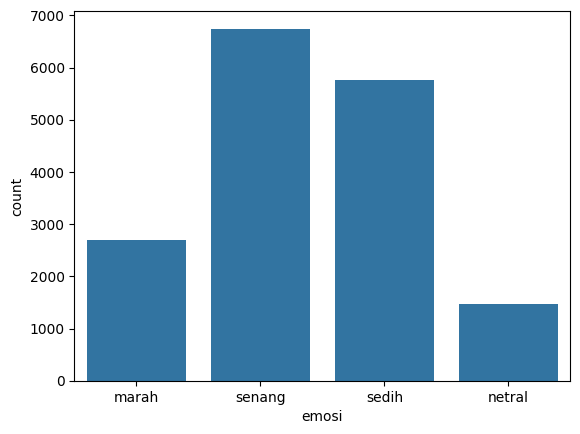

In [57]:
sns.countplot(x=data['emosi'])
plt.show()

# Data Preprocessing
# Encode emotions

In [58]:
lb = LabelEncoder()
data['emosi'] = lb.fit_transform(data['emosi'])

In [59]:
data

,teks,emosi,length
0,aku merasa sangat sinis sekarang,0,32
1,saya merasa murah hati saat ini saya akan menj...,3,66
2,Aku masih merasa ada lebih dari cukup untuk me...,3,102
3,aku merasa semuanya kacau sekali,0,32
4,Aku benar-benar tertawa terbahak-bahak mendeng...,2,125
...,...,...,...
17984,Aku merasakan kesedihan yang luar biasa karena...,0,103
17985,aku merasa semuanya terkendali maka aku baik-b...,3,54
17986,aku merasa kabut emosi akhirnya mulai hilang,2,44
17987,Aku merasa marah pada diriku sendiri karena me...,3,124


# Applying Deep learning Using LSTM

# Text Cleaning, Encoding, and Padding

In [114]:
import concurrent.futures
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download stopwords jika belum ada
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# Menambahkan stopwords khusus yang relevan
additional_stopwords = {'orang', 'rasa', 'asa', 'pikir', 'buat', 'hidup', 'suka'}
stopwords.update(additional_stopwords)

# Inisialisasi stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

negasi_words = ['tidak', 'gak', 'bukan', 'jangan']
intensifikasi_words = ['sangat', 'terlalu', 'amat', 'banget']

# Fungsi untuk menangani negasi dan intensifikasi
def handle_negasi_and_intensifikasi(text):
    words = text.split()
    modified_words = []
    negate_next = False  # Menandai apakah kata berikutnya harus dimodifikasi

    for i, word in enumerate(words):
        # Jika kata negasi ditemukan
        if word in negasi_words:
            negate_next = True
            modified_words.append('_NEG_')
        elif word in intensifikasi_words:
            # Jika kata intensifikasi ditemukan, tambahkan tag intensifikasi
            modified_words.append('_INTENS_')
        else:
            if negate_next:
                # Jika negasi sebelumnya ditemukan, ubah makna kata
                word = 'tidak_' + word
                negate_next = False
            modified_words.append(word)
    
    return " ".join(modified_words)


# Fungsi untuk membersihkan teks
def clean_text(text):
    # Menghapus karakter non-alfabet (kecuali tanda baca tertentu)
    text = re.sub("[^a-zA-Z!?]", " ", text)
    
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    
    text = handle_negasi_and_intensifikasi(text)
    
    # Tokenisasi kata
    words = text.split()
    
    # Menghapus stopwords
    words = [word for word in words if word not in stopwords]
    
    # Lakukan stemming
    words = [stemmer.stem(word) for word in words]
    
    # Gabungkan kata-kata yang sudah diproses menjadi satu string
    return " ".join(words)

# Parallel processing dengan concurrent.futures

def process_batch(batch):
    return [clean_text(text) for text in batch]

# Menyusun data dalam batch
batch_size = 500  # Tentukan ukuran batch
batches = [data['teks'].iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Parallel processing menggunakan ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_batch, batches))

# Gabungkan hasilnya menjadi satu dataframe
processed_data = [item for sublist in results for item in sublist]
data['teks_clean'] = processed_data

# Tokenization
tokenizer = Tokenizer(num_words=11000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['teks_clean'])
sequences = tokenizer.texts_to_sequences(data['teks_clean'])

# Padding sequences untuk panjang input yang konsisten
x = pad_sequences(sequences, maxlen=500, padding='post')

# Label encoding (one-hot encoding)
y = to_categorical(data["emosi"])

# Cek hasil
print(data['teks_clean'].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haldies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                         intens sinis
1                                           murah hati
2                                        hibur selesai
3                                                kacau
4    tertawa bahak bahak dengar nyata nyata buat sedih
Name: teks_clean, dtype: object


In [97]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Output shapes
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (13338, 500), x_test shape: (3335, 500)


In [98]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Fungsi untuk menghitung kata per label
def word_count_per_label(data, label_column, text_column):
    label_word_counts = {}

    # Loop untuk setiap label dalam kolom 'emosi_label'
    for label in data[label_column].unique():
        # Ambil teks yang sesuai dengan label
        label_texts = data[data[label_column] == label][text_column]
        
        # Gabungkan seluruh teks untuk label tersebut menjadi satu string
        all_cleaned_text = " ".join(label_texts)
        
        # Pisahkan string menjadi kata-kata
        words = all_cleaned_text.split()
        
        # Hitung frekuensi kata untuk label tersebut
        word_counts = Counter(words)
        
        # Simpan hasil frekuensi kata per label
        label_word_counts[label] = word_counts

    return label_word_counts

# Mapping label numerik ke emosi
label_mapping = {0: 'marah', 1: 'senang', 2: 'sedih', 3: 'netral'}

# Ganti label numerik dengan label emosi yang lebih mudah dibaca
data['emosi_label'] = data['emosi'].map(label_mapping)

Top 10 Kata untuk Label 'marah':
kesal: 340
marah: 288
rasa: 272
asa: 252
benci: 152
pikir: 149
singgung: 139
diri: 132
buat: 128
ganggu: 125

----------------------------------------


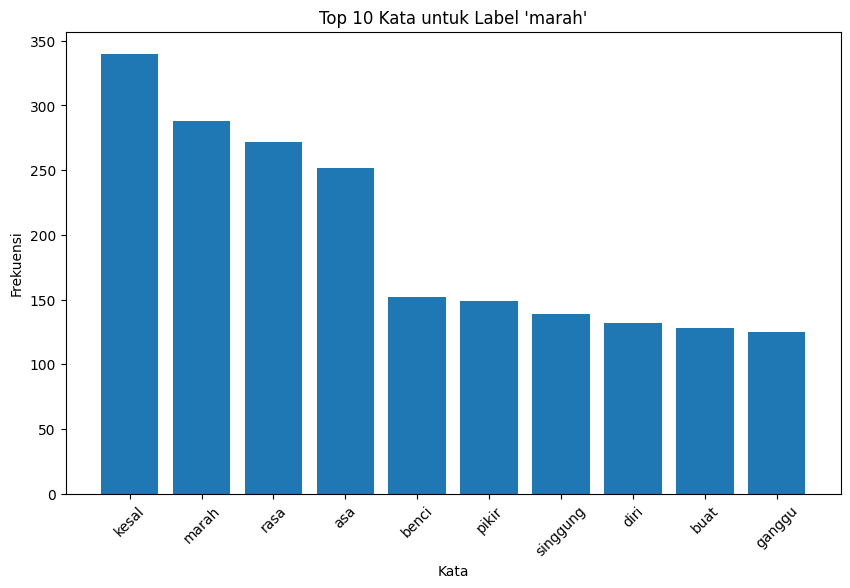

Top 10 Kata untuk Label 'netral':
rasa: 702
asa: 667
senang: 525
harga: 365
milik: 307
buat: 265
anak: 259
terima: 258
puas: 257
pikir: 252

----------------------------------------


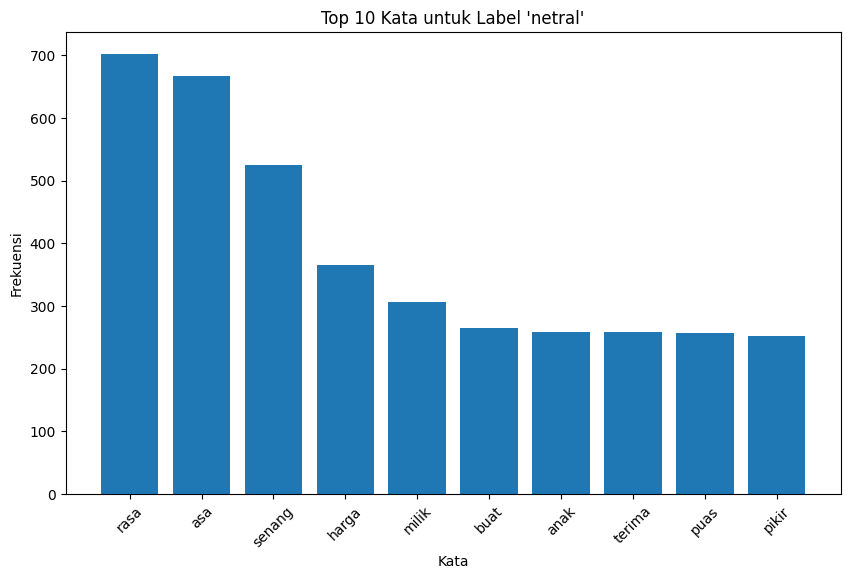

Top 10 Kata untuk Label 'sedih':
asa: 595
rasa: 493
sedih: 325
enak: 319
sakit: 295
diri: 275
salah: 262
bodoh: 261
pikir: 252
buat: 249

----------------------------------------


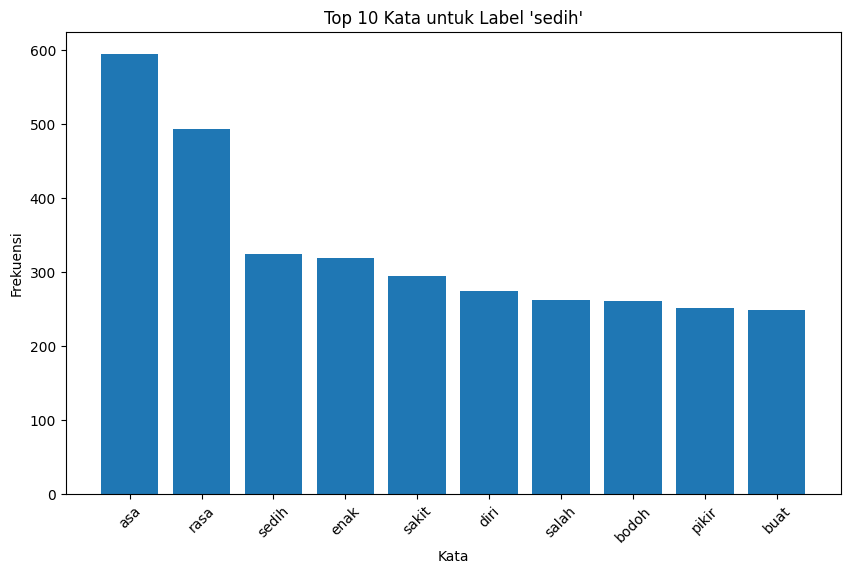

Top 10 Kata untuk Label 'senang':
ya: 83
banget: 68
jalan: 52
ajar: 50
main: 42
oh: 39
hai: 38
laku: 35
ken: 33
anak: 32

----------------------------------------


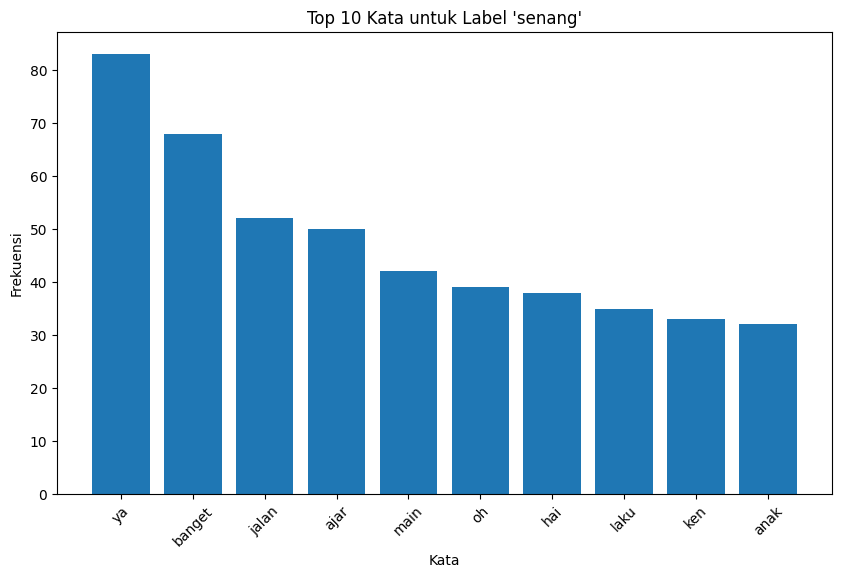

In [ ]:
label_word_counts = word_count_per_label(data, label_column='emosi_label', text_column='teks_clean')

def plot_word_counts(label_word_counts):
    for label, word_counts in label_word_counts.items():
      
        most_common_words = word_counts.most_common(10)
        
        words, counts = zip(*most_common_words)
        
        print(f"Top 10 Kata untuk Label '{label}':")
        for word, count in zip(words, counts):
            print(f"{word}: {count}")
        print("\n" + "-"*40)
        
        plt.figure(figsize=(10, 6))
        plt.bar(words, counts)
        plt.title(f"Top 10 Kata untuk Label '{label}'")
        plt.xlabel("Kata")
        plt.ylabel("Frekuensi")
        plt.xticks(rotation=45)
        plt.show()

plot_word_counts(label_word_counts)

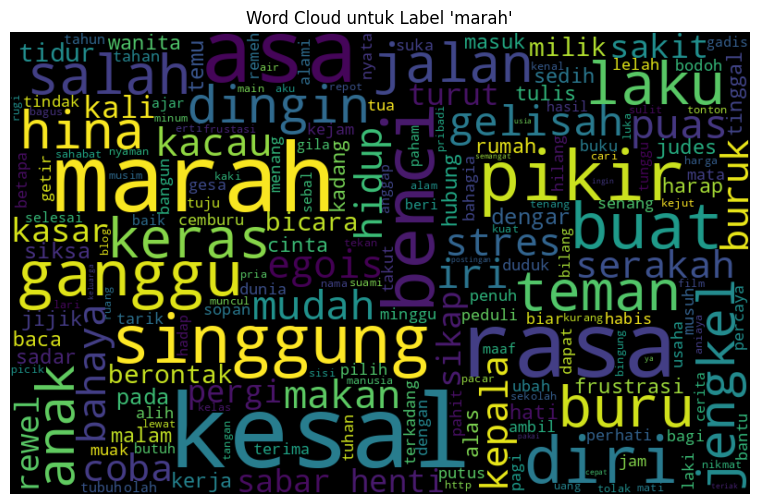

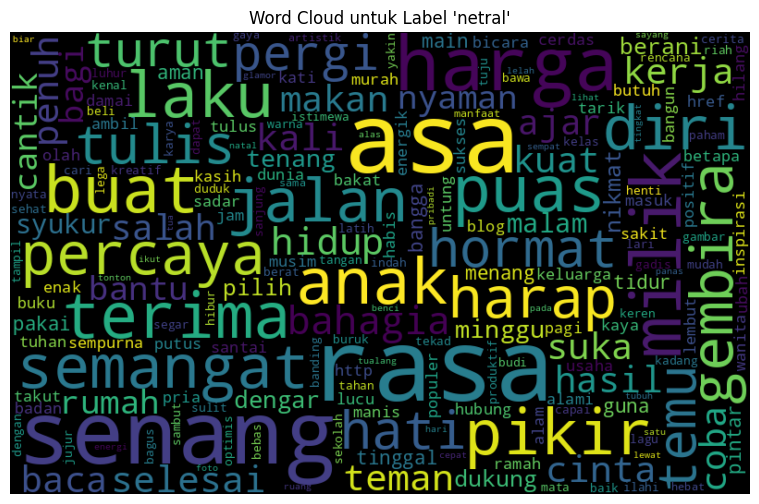

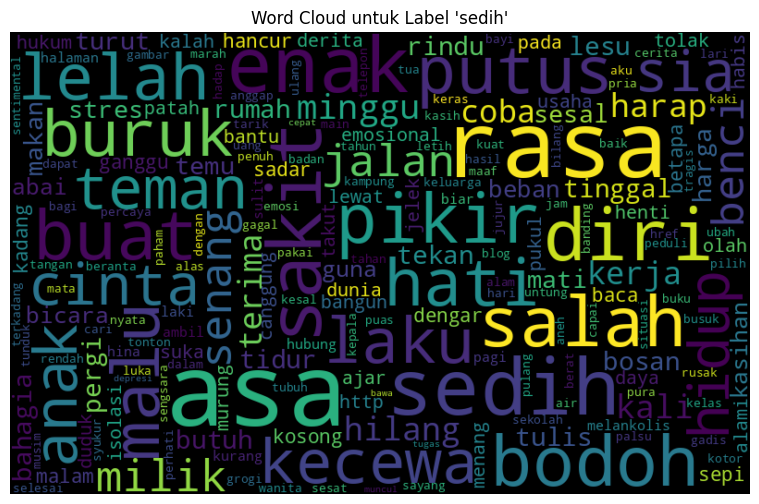

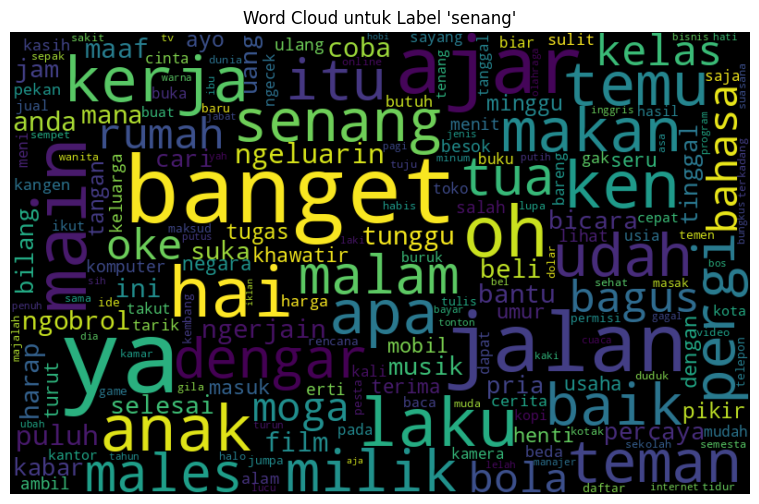

In [ ]:
def plot_wordcloud(label_word_counts):
    for label, word_counts in label_word_counts.items():
        wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(word_counts)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud untuk Label '{label}'")
        plt.show()

plot_wordcloud(label_word_counts)

# Model Building and Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
import numpy as np

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

def create_model(lstm_units=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=11000, output_dim=150, input_length=500))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

param_grid = {
    'lstm_units': [64, 128, 256],  
    'dropout_rate': [0.2, 0.3],    
    'batch_size': [32, 64, 128],   
    'epochs': [10, 20],            
}


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model_for_grid_search = KerasClassifier(build_fn=create_model, verbose=1)

grid_search = GridSearchCV(estimator=model_for_grid_search, param_grid=param_grid, cv=3)


grid_search.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])

print(f"Best hyperparameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_

test_loss, test_acc = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Predictive System

In [ ]:
from sklearn.metrics import classification_report
import numpy as np



report = classification_report(y_true, y_pred, target_names=class_names)


print(report)

              precision    recall  f1-score   support

     Kelas 0       0.67      0.67      0.67         3
     Kelas 1       0.67      0.67      0.67         3
     Kelas 2       0.67      0.67      0.67         3

    accuracy                           0.67         9
   macro avg       0.67      0.67      0.67         9
weighted avg       0.67      0.67      0.67         9



In [115]:
import numpy as np
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords tersedia
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# Tambahkan stopwords khusus
additional_stopwords = {'orang', 'rasa', 'asa', 'pikir', 'buat', 'hidup', 'suka'}
stopwords.update(additional_stopwords)

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi preprocessing kalimat
def sentence_cleaning(sentence, tokenizer, max_length=500):
    text = re.sub("[^a-zA-Z]", " ", sentence)  # Hanya huruf
    text = text.lower()  # Konversi ke huruf kecil
    text = text.split()  # Tokenisasi
    text = [stemmer.stem(word) for word in text if word not in stopwords]  # Stemming dan hapus stopwords
    text = " ".join(text)  # Gabungkan kembali
    sequences = tokenizer.texts_to_sequences([text])  # Konversi teks ke sequences
    pad = pad_sequences(sequences, maxlen=max_length, padding='post')  # Padding sequences
    return pad

# Muat tokenizer (harus sama seperti saat training)
tokenizer = Tokenizer(num_words=11000, oov_token="<OOV>")
tokenizer.fit_on_texts(["dummy"])  # Ini placeholder jika tokenizer belum tersedia

# Muat model
model = load_model('best_model.h5')

# Prediksi
sentences = [
    "asa rasa",
]
label_mapping = {0: 'marah', 1: 'senang', 2: 'sedih', 3: 'netral'}
for sentence in sentences:
    print("Kalimat:", sentence)
    processed_sentence = sentence_cleaning(sentence, tokenizer)
    proba = model.predict(processed_sentence)
    result = np.argmax(proba, axis=-1)[0]  
    print(f"Label Prediksi: {label_mapping[result]} | Probabilitas: {proba[0]}\n")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haldies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Kalimat: asa rasa
1/1 [==============================] - 2s 2s/step
Label Prediksi: senang | Probabilitas: [0.01226721 0.8351153  0.04659812 0.10601943]



# Save the model and files